# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

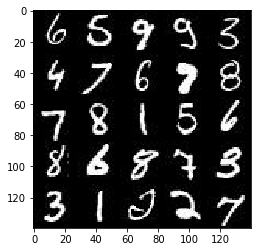

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

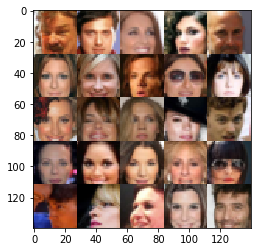

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/giancos/anaconda3/envs/dlnd-Project5/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/giancos/anaconda3/envs/dlnd-Project5/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/giancos/anaconda3/envs/dlnd-Project5/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/giancos/anaconda3/envs/dlnd-Project5/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/giancos/anaconda3/envs/dlnd-Project5/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    leaky_relu = lambda x: tf.maximum(0.01 * x, x)

    def conv(inputs, filters, strides):
        outputs = tf.layers.conv2d(inputs, filters, 5, strides, 'same')
        outputs = tf.layers.batch_normalization(outputs, training=True)
        outputs = leaky_relu(outputs)
        return outputs
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels with NO batch normalization
        # input 28*28*3
        x1 = conv(images, 64, 2) # 14*14*64
        x2 = conv(x1, 128, 2) # 7*7*128
        x3 = conv(x2, 256, 2) # 4*4*256  
        x4 = conv(x3, 512, 2) # 2*2*512  
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_relu = lambda x: tf.maximum(0.01 * x, x)
    
    
    def conv_transpose(inputs, filters, strides):        
        outputs = tf.layers.conv2d_transpose(inputs, filters, 5, strides, 'SAME')
        outputs = tf.layers.batch_normalization(outputs, training=is_train)
        outputs = leaky_relu(outputs)        
        return outputs
    
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
             
        x2 = conv_transpose(x1, 256, 1)       
        x3 = conv_transpose(x2, 128, 2)          
        
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim

    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake))
    g_loss = tf.reduce_mean(g_loss)
    
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9)
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake))
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    d_loss = d_loss_real + d_loss_fake
    

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                    
            show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5994... Generator Loss: 6.2191
Epoch 1/2... Batch 20... Discriminator Loss: 0.6348... Generator Loss: 4.7256
Epoch 1/2... Batch 30... Discriminator Loss: 0.5713... Generator Loss: 2.0953
Epoch 1/2... Batch 40... Discriminator Loss: 0.5570... Generator Loss: 2.1437
Epoch 1/2... Batch 50... Discriminator Loss: 3.9303... Generator Loss: 7.2515
Epoch 1/2... Batch 60... Discriminator Loss: 0.9422... Generator Loss: 2.2153
Epoch 1/2... Batch 70... Discriminator Loss: 0.9066... Generator Loss: 2.1129
Epoch 1/2... Batch 80... Discriminator Loss: 1.4846... Generator Loss: 0.6544
Epoch 1/2... Batch 90... Discriminator Loss: 0.9627... Generator Loss: 1.2924
Epoch 1/2... Batch 100... Discriminator Loss: 1.0791... Generator Loss: 0.9494


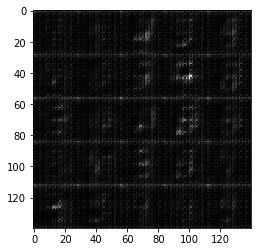

Epoch 1/2... Batch 110... Discriminator Loss: 1.2697... Generator Loss: 1.6348
Epoch 1/2... Batch 120... Discriminator Loss: 1.2781... Generator Loss: 2.4449
Epoch 1/2... Batch 130... Discriminator Loss: 1.1400... Generator Loss: 0.8589
Epoch 1/2... Batch 140... Discriminator Loss: 1.4184... Generator Loss: 0.6251
Epoch 1/2... Batch 150... Discriminator Loss: 1.8229... Generator Loss: 0.3329
Epoch 1/2... Batch 160... Discriminator Loss: 1.1874... Generator Loss: 1.0426
Epoch 1/2... Batch 170... Discriminator Loss: 1.3599... Generator Loss: 0.6582
Epoch 1/2... Batch 180... Discriminator Loss: 1.2492... Generator Loss: 0.8329
Epoch 1/2... Batch 190... Discriminator Loss: 1.3730... Generator Loss: 0.8744
Epoch 1/2... Batch 200... Discriminator Loss: 1.3533... Generator Loss: 0.9368


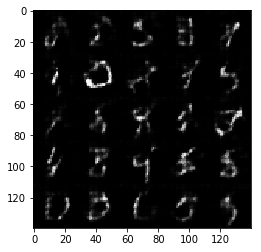

Epoch 1/2... Batch 210... Discriminator Loss: 1.5636... Generator Loss: 1.7557
Epoch 1/2... Batch 220... Discriminator Loss: 1.2465... Generator Loss: 0.8182
Epoch 1/2... Batch 230... Discriminator Loss: 1.2655... Generator Loss: 1.2022
Epoch 1/2... Batch 240... Discriminator Loss: 1.3487... Generator Loss: 1.2279
Epoch 1/2... Batch 250... Discriminator Loss: 1.2352... Generator Loss: 0.7055
Epoch 1/2... Batch 260... Discriminator Loss: 1.1796... Generator Loss: 1.1908
Epoch 1/2... Batch 270... Discriminator Loss: 1.1969... Generator Loss: 0.8758
Epoch 1/2... Batch 280... Discriminator Loss: 1.1037... Generator Loss: 1.2792
Epoch 1/2... Batch 290... Discriminator Loss: 1.3011... Generator Loss: 1.2517
Epoch 1/2... Batch 300... Discriminator Loss: 1.2281... Generator Loss: 0.8129


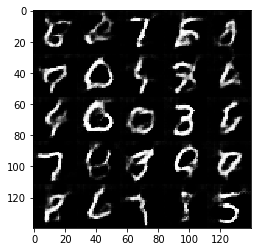

Epoch 1/2... Batch 310... Discriminator Loss: 1.2293... Generator Loss: 1.2666
Epoch 1/2... Batch 320... Discriminator Loss: 1.5829... Generator Loss: 0.4147
Epoch 1/2... Batch 330... Discriminator Loss: 1.2057... Generator Loss: 0.9746
Epoch 1/2... Batch 340... Discriminator Loss: 1.1267... Generator Loss: 1.0194
Epoch 1/2... Batch 350... Discriminator Loss: 1.2052... Generator Loss: 0.9594
Epoch 1/2... Batch 360... Discriminator Loss: 1.4052... Generator Loss: 0.5564
Epoch 1/2... Batch 370... Discriminator Loss: 1.3224... Generator Loss: 0.6943
Epoch 1/2... Batch 380... Discriminator Loss: 1.1825... Generator Loss: 0.8374
Epoch 1/2... Batch 390... Discriminator Loss: 1.1100... Generator Loss: 1.0857
Epoch 1/2... Batch 400... Discriminator Loss: 1.4414... Generator Loss: 0.4606


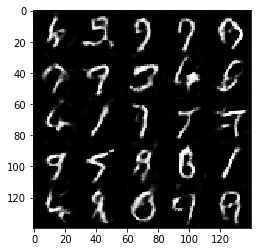

Epoch 1/2... Batch 410... Discriminator Loss: 1.1719... Generator Loss: 1.0554
Epoch 1/2... Batch 420... Discriminator Loss: 1.1394... Generator Loss: 0.9638
Epoch 1/2... Batch 430... Discriminator Loss: 1.2048... Generator Loss: 1.4119
Epoch 1/2... Batch 440... Discriminator Loss: 1.1924... Generator Loss: 0.8350
Epoch 1/2... Batch 450... Discriminator Loss: 1.2812... Generator Loss: 1.7672
Epoch 1/2... Batch 460... Discriminator Loss: 1.1810... Generator Loss: 1.1600


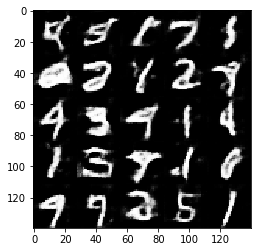

Epoch 2/2... Batch 10... Discriminator Loss: 1.2079... Generator Loss: 0.7154
Epoch 2/2... Batch 20... Discriminator Loss: 1.8643... Generator Loss: 2.5531
Epoch 2/2... Batch 30... Discriminator Loss: 1.2240... Generator Loss: 0.7562
Epoch 2/2... Batch 40... Discriminator Loss: 1.1930... Generator Loss: 1.1012
Epoch 2/2... Batch 50... Discriminator Loss: 1.1274... Generator Loss: 1.1488
Epoch 2/2... Batch 60... Discriminator Loss: 1.1478... Generator Loss: 1.4301
Epoch 2/2... Batch 70... Discriminator Loss: 1.2094... Generator Loss: 1.1910
Epoch 2/2... Batch 80... Discriminator Loss: 1.1675... Generator Loss: 0.7915
Epoch 2/2... Batch 90... Discriminator Loss: 1.1208... Generator Loss: 1.1173
Epoch 2/2... Batch 100... Discriminator Loss: 1.3116... Generator Loss: 0.5749


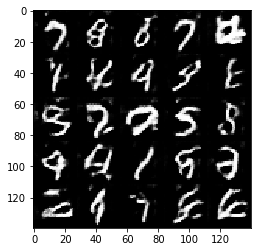

Epoch 2/2... Batch 110... Discriminator Loss: 1.0738... Generator Loss: 1.5695
Epoch 2/2... Batch 120... Discriminator Loss: 1.2390... Generator Loss: 0.7199
Epoch 2/2... Batch 130... Discriminator Loss: 1.0608... Generator Loss: 1.3252
Epoch 2/2... Batch 140... Discriminator Loss: 1.1635... Generator Loss: 0.9311
Epoch 2/2... Batch 150... Discriminator Loss: 1.0846... Generator Loss: 1.0056
Epoch 2/2... Batch 160... Discriminator Loss: 1.2749... Generator Loss: 1.7788
Epoch 2/2... Batch 170... Discriminator Loss: 1.1306... Generator Loss: 1.1986
Epoch 2/2... Batch 180... Discriminator Loss: 1.2469... Generator Loss: 1.3022
Epoch 2/2... Batch 190... Discriminator Loss: 1.5612... Generator Loss: 1.8625
Epoch 2/2... Batch 200... Discriminator Loss: 1.1550... Generator Loss: 0.9351


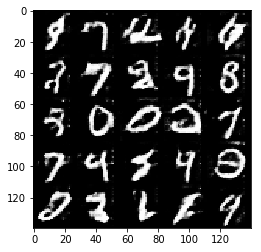

Epoch 2/2... Batch 210... Discriminator Loss: 1.3110... Generator Loss: 0.6131
Epoch 2/2... Batch 220... Discriminator Loss: 1.1061... Generator Loss: 1.3173
Epoch 2/2... Batch 230... Discriminator Loss: 1.0985... Generator Loss: 0.8465
Epoch 2/2... Batch 240... Discriminator Loss: 1.2402... Generator Loss: 0.9927
Epoch 2/2... Batch 250... Discriminator Loss: 1.2196... Generator Loss: 0.9612
Epoch 2/2... Batch 260... Discriminator Loss: 1.2366... Generator Loss: 1.8342
Epoch 2/2... Batch 270... Discriminator Loss: 1.3497... Generator Loss: 0.5552
Epoch 2/2... Batch 280... Discriminator Loss: 1.1800... Generator Loss: 0.8794
Epoch 2/2... Batch 290... Discriminator Loss: 1.2425... Generator Loss: 0.9265
Epoch 2/2... Batch 300... Discriminator Loss: 1.0884... Generator Loss: 1.7503


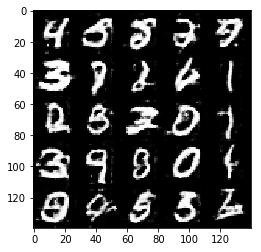

Epoch 2/2... Batch 310... Discriminator Loss: 1.1721... Generator Loss: 0.8095
Epoch 2/2... Batch 320... Discriminator Loss: 1.2825... Generator Loss: 1.6913
Epoch 2/2... Batch 330... Discriminator Loss: 1.4838... Generator Loss: 0.6345
Epoch 2/2... Batch 340... Discriminator Loss: 1.0488... Generator Loss: 1.4072
Epoch 2/2... Batch 350... Discriminator Loss: 1.2332... Generator Loss: 0.7796
Epoch 2/2... Batch 360... Discriminator Loss: 1.0182... Generator Loss: 1.2177
Epoch 2/2... Batch 370... Discriminator Loss: 0.9540... Generator Loss: 1.5254
Epoch 2/2... Batch 380... Discriminator Loss: 1.0409... Generator Loss: 1.0340
Epoch 2/2... Batch 390... Discriminator Loss: 0.9737... Generator Loss: 1.0506
Epoch 2/2... Batch 400... Discriminator Loss: 1.0555... Generator Loss: 1.0992


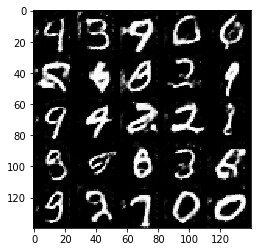

Epoch 2/2... Batch 410... Discriminator Loss: 1.0415... Generator Loss: 1.3609
Epoch 2/2... Batch 420... Discriminator Loss: 1.4356... Generator Loss: 0.5105
Epoch 2/2... Batch 430... Discriminator Loss: 0.9238... Generator Loss: 1.3144
Epoch 2/2... Batch 440... Discriminator Loss: 1.3894... Generator Loss: 0.5483
Epoch 2/2... Batch 450... Discriminator Loss: 1.1601... Generator Loss: 1.1726
Epoch 2/2... Batch 460... Discriminator Loss: 1.1128... Generator Loss: 0.8536


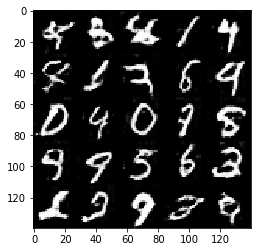

In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 2.4922... Generator Loss: 0.1539
Epoch 1/1... Batch 20... Discriminator Loss: 1.1165... Generator Loss: 0.8674
Epoch 1/1... Batch 30... Discriminator Loss: 1.3315... Generator Loss: 0.5588
Epoch 1/1... Batch 40... Discriminator Loss: 0.9087... Generator Loss: 1.0537
Epoch 1/1... Batch 50... Discriminator Loss: 0.8880... Generator Loss: 2.1264
Epoch 1/1... Batch 60... Discriminator Loss: 0.5921... Generator Loss: 2.5175
Epoch 1/1... Batch 70... Discriminator Loss: 0.8756... Generator Loss: 1.1441
Epoch 1/1... Batch 80... Discriminator Loss: 0.9044... Generator Loss: 1.7931
Epoch 1/1... Batch 90... Discriminator Loss: 0.8175... Generator Loss: 1.6486
Epoch 1/1... Batch 100... Discriminator Loss: 0.6672... Generator Loss: 2.1264


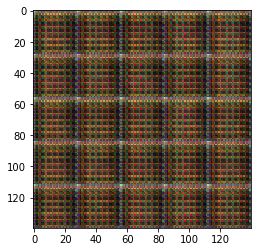

Epoch 1/1... Batch 110... Discriminator Loss: 0.5770... Generator Loss: 2.4198
Epoch 1/1... Batch 120... Discriminator Loss: 0.7825... Generator Loss: 1.3904
Epoch 1/1... Batch 130... Discriminator Loss: 0.7708... Generator Loss: 1.3691
Epoch 1/1... Batch 140... Discriminator Loss: 0.6258... Generator Loss: 1.6725
Epoch 1/1... Batch 150... Discriminator Loss: 0.6769... Generator Loss: 1.5876
Epoch 1/1... Batch 160... Discriminator Loss: 0.6737... Generator Loss: 1.5179
Epoch 1/1... Batch 170... Discriminator Loss: 1.3546... Generator Loss: 0.5410
Epoch 1/1... Batch 180... Discriminator Loss: 0.9138... Generator Loss: 1.2258
Epoch 1/1... Batch 190... Discriminator Loss: 0.9191... Generator Loss: 1.5049
Epoch 1/1... Batch 200... Discriminator Loss: 1.6937... Generator Loss: 0.3735


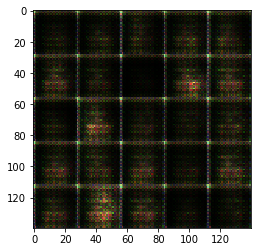

Epoch 1/1... Batch 210... Discriminator Loss: 1.1728... Generator Loss: 0.7668
Epoch 1/1... Batch 220... Discriminator Loss: 1.2398... Generator Loss: 0.7116
Epoch 1/1... Batch 230... Discriminator Loss: 1.1507... Generator Loss: 0.7539
Epoch 1/1... Batch 240... Discriminator Loss: 1.1157... Generator Loss: 0.8879
Epoch 1/1... Batch 250... Discriminator Loss: 1.1941... Generator Loss: 0.9253
Epoch 1/1... Batch 260... Discriminator Loss: 1.0538... Generator Loss: 1.7841
Epoch 1/1... Batch 270... Discriminator Loss: 1.0437... Generator Loss: 1.2962
Epoch 1/1... Batch 280... Discriminator Loss: 0.8845... Generator Loss: 1.1670
Epoch 1/1... Batch 290... Discriminator Loss: 1.0253... Generator Loss: 1.0386
Epoch 1/1... Batch 300... Discriminator Loss: 1.0759... Generator Loss: 0.7890


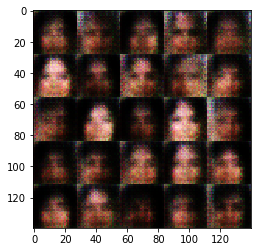

Epoch 1/1... Batch 310... Discriminator Loss: 0.8589... Generator Loss: 1.0676
Epoch 1/1... Batch 320... Discriminator Loss: 1.0058... Generator Loss: 1.0771
Epoch 1/1... Batch 330... Discriminator Loss: 0.8796... Generator Loss: 1.0478
Epoch 1/1... Batch 340... Discriminator Loss: 1.0882... Generator Loss: 2.1253
Epoch 1/1... Batch 350... Discriminator Loss: 0.7406... Generator Loss: 1.7144
Epoch 1/1... Batch 360... Discriminator Loss: 0.8870... Generator Loss: 2.2050
Epoch 1/1... Batch 370... Discriminator Loss: 0.9223... Generator Loss: 2.5187
Epoch 1/1... Batch 380... Discriminator Loss: 0.9564... Generator Loss: 1.3458
Epoch 1/1... Batch 390... Discriminator Loss: 0.8843... Generator Loss: 1.3560
Epoch 1/1... Batch 400... Discriminator Loss: 1.3622... Generator Loss: 0.5483


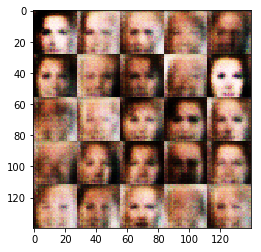

Epoch 1/1... Batch 410... Discriminator Loss: 0.9865... Generator Loss: 0.9351
Epoch 1/1... Batch 420... Discriminator Loss: 1.0028... Generator Loss: 1.2958
Epoch 1/1... Batch 430... Discriminator Loss: 0.8852... Generator Loss: 1.1583
Epoch 1/1... Batch 440... Discriminator Loss: 1.3403... Generator Loss: 0.5772
Epoch 1/1... Batch 450... Discriminator Loss: 0.9818... Generator Loss: 1.1160
Epoch 1/1... Batch 460... Discriminator Loss: 0.7599... Generator Loss: 1.8118
Epoch 1/1... Batch 470... Discriminator Loss: 0.8362... Generator Loss: 1.2474
Epoch 1/1... Batch 480... Discriminator Loss: 0.9170... Generator Loss: 1.2429
Epoch 1/1... Batch 490... Discriminator Loss: 1.0104... Generator Loss: 0.9604
Epoch 1/1... Batch 500... Discriminator Loss: 0.8434... Generator Loss: 1.5838


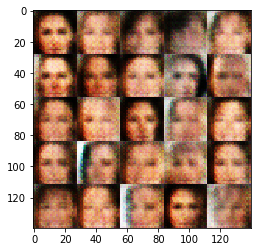

Epoch 1/1... Batch 510... Discriminator Loss: 1.3406... Generator Loss: 0.5371
Epoch 1/1... Batch 520... Discriminator Loss: 1.0402... Generator Loss: 0.9922
Epoch 1/1... Batch 530... Discriminator Loss: 1.0406... Generator Loss: 1.0246
Epoch 1/1... Batch 540... Discriminator Loss: 1.0299... Generator Loss: 1.4834
Epoch 1/1... Batch 550... Discriminator Loss: 1.3073... Generator Loss: 0.5853
Epoch 1/1... Batch 560... Discriminator Loss: 1.0744... Generator Loss: 1.0034
Epoch 1/1... Batch 570... Discriminator Loss: 1.0286... Generator Loss: 0.9423
Epoch 1/1... Batch 580... Discriminator Loss: 1.0640... Generator Loss: 0.8374
Epoch 1/1... Batch 590... Discriminator Loss: 1.0424... Generator Loss: 0.7962
Epoch 1/1... Batch 600... Discriminator Loss: 1.0863... Generator Loss: 0.8643


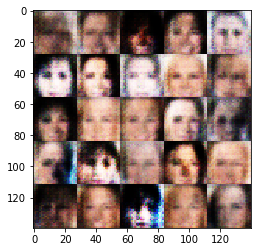

Epoch 1/1... Batch 610... Discriminator Loss: 1.6059... Generator Loss: 0.3923
Epoch 1/1... Batch 620... Discriminator Loss: 1.0568... Generator Loss: 1.6870
Epoch 1/1... Batch 630... Discriminator Loss: 1.3332... Generator Loss: 0.5779
Epoch 1/1... Batch 640... Discriminator Loss: 1.0696... Generator Loss: 1.3905
Epoch 1/1... Batch 650... Discriminator Loss: 0.9029... Generator Loss: 1.3542
Epoch 1/1... Batch 660... Discriminator Loss: 1.1017... Generator Loss: 1.5850
Epoch 1/1... Batch 670... Discriminator Loss: 1.0893... Generator Loss: 1.0556
Epoch 1/1... Batch 680... Discriminator Loss: 1.0874... Generator Loss: 1.1376
Epoch 1/1... Batch 690... Discriminator Loss: 1.3266... Generator Loss: 1.6816
Epoch 1/1... Batch 700... Discriminator Loss: 1.4705... Generator Loss: 0.4672


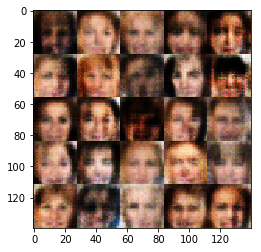

Epoch 1/1... Batch 710... Discriminator Loss: 1.0379... Generator Loss: 0.9306
Epoch 1/1... Batch 720... Discriminator Loss: 1.1722... Generator Loss: 0.7102
Epoch 1/1... Batch 730... Discriminator Loss: 1.3087... Generator Loss: 0.5776
Epoch 1/1... Batch 740... Discriminator Loss: 1.4539... Generator Loss: 0.4637
Epoch 1/1... Batch 750... Discriminator Loss: 1.1401... Generator Loss: 1.0851
Epoch 1/1... Batch 760... Discriminator Loss: 0.9400... Generator Loss: 1.3379
Epoch 1/1... Batch 770... Discriminator Loss: 1.1869... Generator Loss: 1.5912
Epoch 1/1... Batch 780... Discriminator Loss: 1.1527... Generator Loss: 0.7607
Epoch 1/1... Batch 790... Discriminator Loss: 1.2264... Generator Loss: 1.4818
Epoch 1/1... Batch 800... Discriminator Loss: 1.2590... Generator Loss: 0.6054


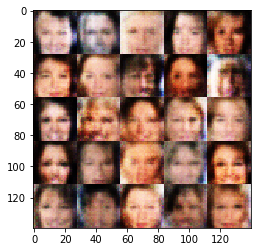

Epoch 1/1... Batch 810... Discriminator Loss: 1.2624... Generator Loss: 0.6279
Epoch 1/1... Batch 820... Discriminator Loss: 1.1857... Generator Loss: 0.7028
Epoch 1/1... Batch 830... Discriminator Loss: 1.4364... Generator Loss: 0.4754
Epoch 1/1... Batch 840... Discriminator Loss: 0.9294... Generator Loss: 1.5108
Epoch 1/1... Batch 850... Discriminator Loss: 0.9812... Generator Loss: 0.9603
Epoch 1/1... Batch 860... Discriminator Loss: 1.4881... Generator Loss: 1.6863
Epoch 1/1... Batch 870... Discriminator Loss: 1.0532... Generator Loss: 1.3707
Epoch 1/1... Batch 880... Discriminator Loss: 1.4028... Generator Loss: 0.4738
Epoch 1/1... Batch 890... Discriminator Loss: 1.0668... Generator Loss: 0.8177
Epoch 1/1... Batch 900... Discriminator Loss: 1.0106... Generator Loss: 1.4349


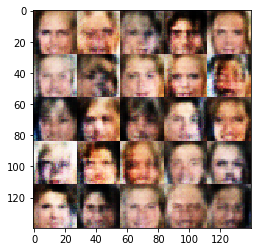

Epoch 1/1... Batch 910... Discriminator Loss: 1.1292... Generator Loss: 0.7815
Epoch 1/1... Batch 920... Discriminator Loss: 1.3306... Generator Loss: 0.5307
Epoch 1/1... Batch 930... Discriminator Loss: 1.1886... Generator Loss: 1.2202
Epoch 1/1... Batch 940... Discriminator Loss: 1.1437... Generator Loss: 0.6978
Epoch 1/1... Batch 950... Discriminator Loss: 1.3392... Generator Loss: 0.5889
Epoch 1/1... Batch 960... Discriminator Loss: 1.0021... Generator Loss: 1.0646
Epoch 1/1... Batch 970... Discriminator Loss: 1.2039... Generator Loss: 0.6400
Epoch 1/1... Batch 980... Discriminator Loss: 1.3017... Generator Loss: 0.5684
Epoch 1/1... Batch 990... Discriminator Loss: 1.7737... Generator Loss: 0.3080
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1248... Generator Loss: 0.7019


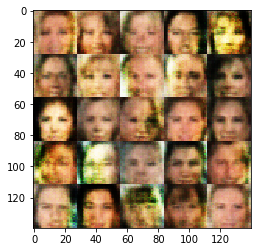

Epoch 1/1... Batch 1010... Discriminator Loss: 0.8909... Generator Loss: 1.0722
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2450... Generator Loss: 0.6358
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2640... Generator Loss: 0.7163
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4946... Generator Loss: 0.4557
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1040... Generator Loss: 1.1161
Epoch 1/1... Batch 1060... Discriminator Loss: 1.5120... Generator Loss: 0.4341
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2155... Generator Loss: 0.9958
Epoch 1/1... Batch 1080... Discriminator Loss: 1.1583... Generator Loss: 1.0314
Epoch 1/1... Batch 1090... Discriminator Loss: 1.4766... Generator Loss: 1.6913
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1739... Generator Loss: 1.1449


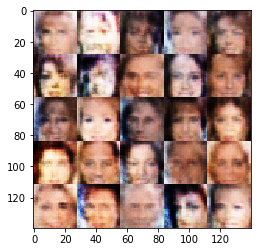

Epoch 1/1... Batch 1110... Discriminator Loss: 1.4069... Generator Loss: 1.7063
Epoch 1/1... Batch 1120... Discriminator Loss: 0.9562... Generator Loss: 1.0104
Epoch 1/1... Batch 1130... Discriminator Loss: 1.1908... Generator Loss: 0.6565
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2279... Generator Loss: 1.4056
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1471... Generator Loss: 0.8458
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2089... Generator Loss: 0.7420
Epoch 1/1... Batch 1170... Discriminator Loss: 0.9584... Generator Loss: 1.2545
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4851... Generator Loss: 0.4397
Epoch 1/1... Batch 1190... Discriminator Loss: 1.2950... Generator Loss: 0.5604
Epoch 1/1... Batch 1200... Discriminator Loss: 1.0205... Generator Loss: 0.9444


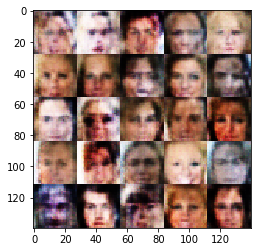

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1218... Generator Loss: 1.3467
Epoch 1/1... Batch 1220... Discriminator Loss: 0.8810... Generator Loss: 1.2228
Epoch 1/1... Batch 1230... Discriminator Loss: 0.9831... Generator Loss: 1.0621
Epoch 1/1... Batch 1240... Discriminator Loss: 0.9658... Generator Loss: 1.0391
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1870... Generator Loss: 0.8745
Epoch 1/1... Batch 1260... Discriminator Loss: 1.5716... Generator Loss: 0.4169
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9355... Generator Loss: 1.3482
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1656... Generator Loss: 0.7441
Epoch 1/1... Batch 1290... Discriminator Loss: 1.8729... Generator Loss: 1.7225
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9459... Generator Loss: 1.2423


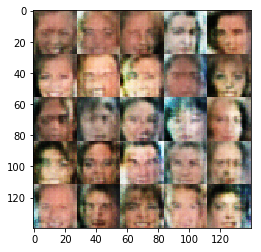

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1363... Generator Loss: 0.7871
Epoch 1/1... Batch 1320... Discriminator Loss: 0.8778... Generator Loss: 1.4326
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3647... Generator Loss: 0.5717
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1593... Generator Loss: 0.6807
Epoch 1/1... Batch 1350... Discriminator Loss: 1.0805... Generator Loss: 0.7973
Epoch 1/1... Batch 1360... Discriminator Loss: 1.1730... Generator Loss: 1.7106
Epoch 1/1... Batch 1370... Discriminator Loss: 1.6081... Generator Loss: 0.3737
Epoch 1/1... Batch 1380... Discriminator Loss: 1.1538... Generator Loss: 1.0827
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4588... Generator Loss: 0.5093
Epoch 1/1... Batch 1400... Discriminator Loss: 1.2937... Generator Loss: 0.6855


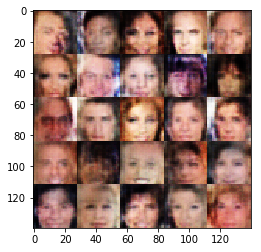

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2439... Generator Loss: 0.8844
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0606... Generator Loss: 0.9456
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2287... Generator Loss: 0.7759
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3240... Generator Loss: 0.5623
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2520... Generator Loss: 0.7666
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2035... Generator Loss: 0.8156
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3053... Generator Loss: 0.5826
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1143... Generator Loss: 0.9935
Epoch 1/1... Batch 1490... Discriminator Loss: 1.1612... Generator Loss: 1.1130
Epoch 1/1... Batch 1500... Discriminator Loss: 1.0422... Generator Loss: 0.9576


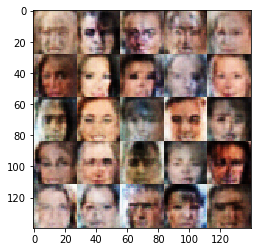

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3578... Generator Loss: 0.6346
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2452... Generator Loss: 0.6978
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1777... Generator Loss: 0.9196
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1548... Generator Loss: 1.3234
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1385... Generator Loss: 1.0583
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4721... Generator Loss: 0.4760
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3359... Generator Loss: 0.6682
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2937... Generator Loss: 0.8564
Epoch 1/1... Batch 1590... Discriminator Loss: 1.2087... Generator Loss: 0.8917
Epoch 1/1... Batch 1600... Discriminator Loss: 1.2588... Generator Loss: 0.7489


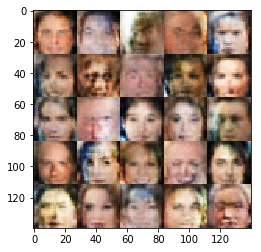

Epoch 1/1... Batch 1610... Discriminator Loss: 1.1673... Generator Loss: 0.7562
Epoch 1/1... Batch 1620... Discriminator Loss: 1.3654... Generator Loss: 0.6126
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2902... Generator Loss: 0.7266
Epoch 1/1... Batch 1640... Discriminator Loss: 1.0887... Generator Loss: 0.8602
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2478... Generator Loss: 0.7449
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1904... Generator Loss: 0.8759
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2399... Generator Loss: 0.7576
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2186... Generator Loss: 0.6971
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2972... Generator Loss: 0.6597
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3340... Generator Loss: 0.6529


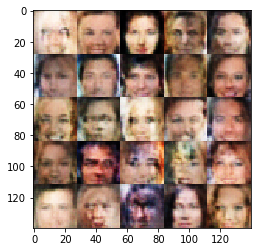

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1140... Generator Loss: 0.9448
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1451... Generator Loss: 0.8907
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3628... Generator Loss: 0.6864
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2659... Generator Loss: 0.7111
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3723... Generator Loss: 0.7209
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3291... Generator Loss: 0.6647
Epoch 1/1... Batch 1770... Discriminator Loss: 1.2632... Generator Loss: 0.8506
Epoch 1/1... Batch 1780... Discriminator Loss: 1.2504... Generator Loss: 0.7003
Epoch 1/1... Batch 1790... Discriminator Loss: 1.3168... Generator Loss: 0.7628
Epoch 1/1... Batch 1800... Discriminator Loss: 1.2521... Generator Loss: 0.7873


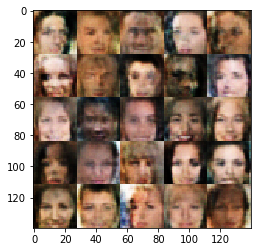

Epoch 1/1... Batch 1810... Discriminator Loss: 1.2283... Generator Loss: 0.6883
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2695... Generator Loss: 0.6655
Epoch 1/1... Batch 1830... Discriminator Loss: 1.2528... Generator Loss: 0.8740
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4199... Generator Loss: 0.5444
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2635... Generator Loss: 0.7337
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2255... Generator Loss: 0.7052
Epoch 1/1... Batch 1870... Discriminator Loss: 1.2201... Generator Loss: 0.8201
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1443... Generator Loss: 0.9237
Epoch 1/1... Batch 1890... Discriminator Loss: 1.2672... Generator Loss: 0.6437
Epoch 1/1... Batch 1900... Discriminator Loss: 1.4991... Generator Loss: 0.4643


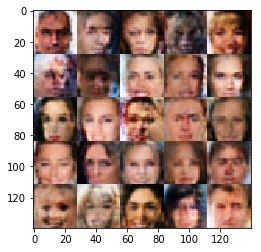

Epoch 1/1... Batch 1910... Discriminator Loss: 1.4939... Generator Loss: 0.4940
Epoch 1/1... Batch 1920... Discriminator Loss: 1.5986... Generator Loss: 0.4633
Epoch 1/1... Batch 1930... Discriminator Loss: 1.2235... Generator Loss: 0.7143
Epoch 1/1... Batch 1940... Discriminator Loss: 1.0897... Generator Loss: 0.9094
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2998... Generator Loss: 0.7650
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3461... Generator Loss: 0.5442
Epoch 1/1... Batch 1970... Discriminator Loss: 1.5491... Generator Loss: 0.4234
Epoch 1/1... Batch 1980... Discriminator Loss: 1.2320... Generator Loss: 0.8475
Epoch 1/1... Batch 1990... Discriminator Loss: 1.3798... Generator Loss: 0.6320
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3979... Generator Loss: 0.5519


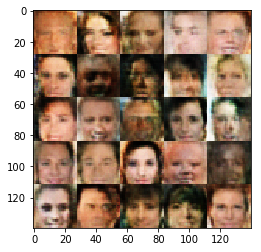

Epoch 1/1... Batch 2010... Discriminator Loss: 1.2584... Generator Loss: 0.7484
Epoch 1/1... Batch 2020... Discriminator Loss: 1.4617... Generator Loss: 0.5500
Epoch 1/1... Batch 2030... Discriminator Loss: 1.4178... Generator Loss: 0.5111
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2812... Generator Loss: 0.7066
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2128... Generator Loss: 0.7832
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1742... Generator Loss: 0.8891
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2824... Generator Loss: 0.7717
Epoch 1/1... Batch 2080... Discriminator Loss: 1.4490... Generator Loss: 0.5556
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2208... Generator Loss: 0.7539
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3366... Generator Loss: 0.8981


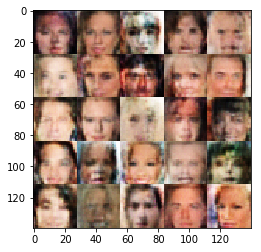

Epoch 1/1... Batch 2110... Discriminator Loss: 1.4050... Generator Loss: 0.5410
Epoch 1/1... Batch 2120... Discriminator Loss: 1.3789... Generator Loss: 0.6267
Epoch 1/1... Batch 2130... Discriminator Loss: 1.4061... Generator Loss: 0.5696
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3034... Generator Loss: 0.7917
Epoch 1/1... Batch 2150... Discriminator Loss: 1.2773... Generator Loss: 0.8165
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4431... Generator Loss: 0.5483
Epoch 1/1... Batch 2170... Discriminator Loss: 1.4055... Generator Loss: 0.5205
Epoch 1/1... Batch 2180... Discriminator Loss: 1.3802... Generator Loss: 0.7381
Epoch 1/1... Batch 2190... Discriminator Loss: 1.3401... Generator Loss: 0.5914
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3106... Generator Loss: 0.6249


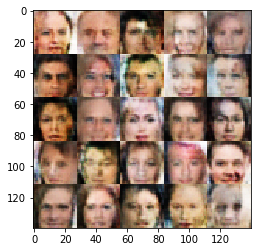

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4580... Generator Loss: 0.4947
Epoch 1/1... Batch 2220... Discriminator Loss: 1.1472... Generator Loss: 1.0142
Epoch 1/1... Batch 2230... Discriminator Loss: 1.4876... Generator Loss: 0.6225
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2654... Generator Loss: 0.7992
Epoch 1/1... Batch 2250... Discriminator Loss: 1.0696... Generator Loss: 1.1241
Epoch 1/1... Batch 2260... Discriminator Loss: 1.3997... Generator Loss: 0.5260
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2100... Generator Loss: 0.7089
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2968... Generator Loss: 0.8733
Epoch 1/1... Batch 2290... Discriminator Loss: 1.3559... Generator Loss: 0.9445
Epoch 1/1... Batch 2300... Discriminator Loss: 1.4146... Generator Loss: 0.5916


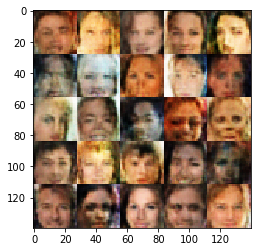

Epoch 1/1... Batch 2310... Discriminator Loss: 1.4273... Generator Loss: 0.4958
Epoch 1/1... Batch 2320... Discriminator Loss: 1.2846... Generator Loss: 0.6975
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2721... Generator Loss: 0.8738
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3193... Generator Loss: 0.7146
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3853... Generator Loss: 0.6555
Epoch 1/1... Batch 2360... Discriminator Loss: 1.3448... Generator Loss: 0.5839
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4199... Generator Loss: 0.5080
Epoch 1/1... Batch 2380... Discriminator Loss: 1.2522... Generator Loss: 0.6498
Epoch 1/1... Batch 2390... Discriminator Loss: 1.3251... Generator Loss: 0.8187
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1085... Generator Loss: 0.8962


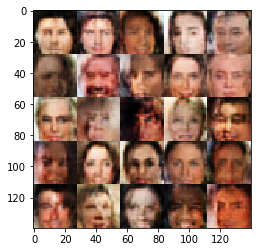

Epoch 1/1... Batch 2410... Discriminator Loss: 1.2790... Generator Loss: 0.7183
Epoch 1/1... Batch 2420... Discriminator Loss: 1.2867... Generator Loss: 0.6202
Epoch 1/1... Batch 2430... Discriminator Loss: 1.1853... Generator Loss: 0.7977
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3574... Generator Loss: 0.5517
Epoch 1/1... Batch 2450... Discriminator Loss: 1.2159... Generator Loss: 0.7919
Epoch 1/1... Batch 2460... Discriminator Loss: 1.2922... Generator Loss: 0.7036
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3649... Generator Loss: 1.0112
Epoch 1/1... Batch 2480... Discriminator Loss: 1.2937... Generator Loss: 0.6637
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2745... Generator Loss: 0.6547
Epoch 1/1... Batch 2500... Discriminator Loss: 1.4166... Generator Loss: 0.5907


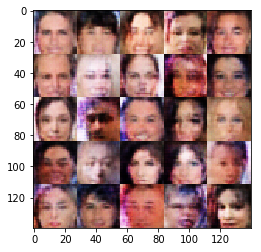

Epoch 1/1... Batch 2510... Discriminator Loss: 1.4070... Generator Loss: 1.1145
Epoch 1/1... Batch 2520... Discriminator Loss: 1.2229... Generator Loss: 0.6713
Epoch 1/1... Batch 2530... Discriminator Loss: 1.0860... Generator Loss: 1.1627
Epoch 1/1... Batch 2540... Discriminator Loss: 1.2142... Generator Loss: 0.7788
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3184... Generator Loss: 0.6358
Epoch 1/1... Batch 2560... Discriminator Loss: 1.3029... Generator Loss: 0.6739
Epoch 1/1... Batch 2570... Discriminator Loss: 1.3786... Generator Loss: 0.5449
Epoch 1/1... Batch 2580... Discriminator Loss: 1.3967... Generator Loss: 0.6519
Epoch 1/1... Batch 2590... Discriminator Loss: 1.3123... Generator Loss: 0.5920
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3405... Generator Loss: 0.6206


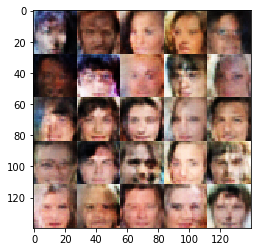

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3207... Generator Loss: 0.7186
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2485... Generator Loss: 0.9286
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1052... Generator Loss: 1.1478
Epoch 1/1... Batch 2640... Discriminator Loss: 1.4709... Generator Loss: 0.7071
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1906... Generator Loss: 0.8877
Epoch 1/1... Batch 2660... Discriminator Loss: 1.3029... Generator Loss: 0.7100
Epoch 1/1... Batch 2670... Discriminator Loss: 1.3670... Generator Loss: 0.6714
Epoch 1/1... Batch 2680... Discriminator Loss: 1.0937... Generator Loss: 1.0695
Epoch 1/1... Batch 2690... Discriminator Loss: 1.1100... Generator Loss: 0.8648
Epoch 1/1... Batch 2700... Discriminator Loss: 1.2070... Generator Loss: 0.8643


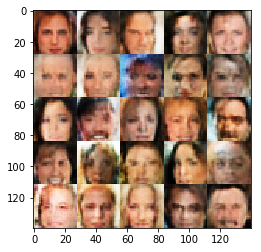

Epoch 1/1... Batch 2710... Discriminator Loss: 1.2019... Generator Loss: 0.8514
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2483... Generator Loss: 0.9708
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3142... Generator Loss: 0.6091
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2850... Generator Loss: 0.8170
Epoch 1/1... Batch 2750... Discriminator Loss: 1.5326... Generator Loss: 0.4471
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2982... Generator Loss: 0.8782
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2943... Generator Loss: 0.6883
Epoch 1/1... Batch 2780... Discriminator Loss: 1.4447... Generator Loss: 0.5383
Epoch 1/1... Batch 2790... Discriminator Loss: 1.4202... Generator Loss: 0.7578
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1743... Generator Loss: 1.0603


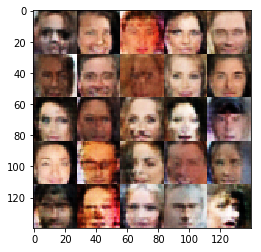

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1928... Generator Loss: 0.7396
Epoch 1/1... Batch 2820... Discriminator Loss: 1.5092... Generator Loss: 0.5122
Epoch 1/1... Batch 2830... Discriminator Loss: 1.6979... Generator Loss: 0.3667
Epoch 1/1... Batch 2840... Discriminator Loss: 1.5051... Generator Loss: 0.6374
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2850... Generator Loss: 0.7383
Epoch 1/1... Batch 2860... Discriminator Loss: 1.1554... Generator Loss: 0.7129
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1773... Generator Loss: 0.8041
Epoch 1/1... Batch 2880... Discriminator Loss: 1.1536... Generator Loss: 1.0365
Epoch 1/1... Batch 2890... Discriminator Loss: 1.1325... Generator Loss: 0.8302
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4815... Generator Loss: 0.4446


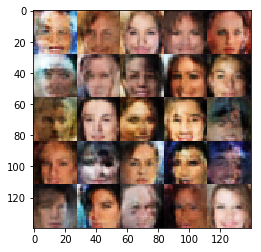

Epoch 1/1... Batch 2910... Discriminator Loss: 1.5490... Generator Loss: 0.4708
Epoch 1/1... Batch 2920... Discriminator Loss: 1.3470... Generator Loss: 0.7418
Epoch 1/1... Batch 2930... Discriminator Loss: 1.2722... Generator Loss: 0.6849
Epoch 1/1... Batch 2940... Discriminator Loss: 1.4205... Generator Loss: 0.6460
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2790... Generator Loss: 0.6322
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2454... Generator Loss: 0.7600
Epoch 1/1... Batch 2970... Discriminator Loss: 1.0766... Generator Loss: 0.9077
Epoch 1/1... Batch 2980... Discriminator Loss: 1.5109... Generator Loss: 0.4849
Epoch 1/1... Batch 2990... Discriminator Loss: 1.3863... Generator Loss: 0.9092
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3496... Generator Loss: 0.6080


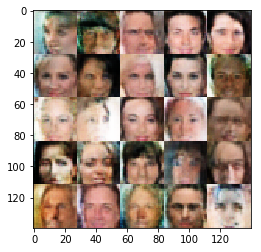

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2888... Generator Loss: 0.6977
Epoch 1/1... Batch 3020... Discriminator Loss: 1.1855... Generator Loss: 0.8348
Epoch 1/1... Batch 3030... Discriminator Loss: 1.2615... Generator Loss: 0.6926
Epoch 1/1... Batch 3040... Discriminator Loss: 1.4001... Generator Loss: 0.5200
Epoch 1/1... Batch 3050... Discriminator Loss: 1.5370... Generator Loss: 0.4525
Epoch 1/1... Batch 3060... Discriminator Loss: 1.3661... Generator Loss: 0.5684
Epoch 1/1... Batch 3070... Discriminator Loss: 1.3623... Generator Loss: 0.6787
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2429... Generator Loss: 0.6892
Epoch 1/1... Batch 3090... Discriminator Loss: 1.2892... Generator Loss: 0.6685
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3385... Generator Loss: 0.6395


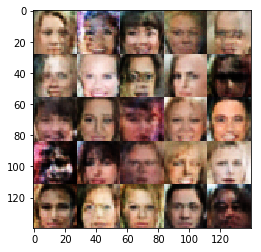

Epoch 1/1... Batch 3110... Discriminator Loss: 1.0726... Generator Loss: 0.9343
Epoch 1/1... Batch 3120... Discriminator Loss: 1.2310... Generator Loss: 0.6468
Epoch 1/1... Batch 3130... Discriminator Loss: 1.2445... Generator Loss: 1.0430
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2099... Generator Loss: 0.8927
Epoch 1/1... Batch 3150... Discriminator Loss: 1.5485... Generator Loss: 0.4204
Epoch 1/1... Batch 3160... Discriminator Loss: 1.5608... Generator Loss: 0.5023
Epoch 1/1... Batch 3170... Discriminator Loss: 1.4437... Generator Loss: 0.5198
Epoch 1/1... Batch 3180... Discriminator Loss: 1.2695... Generator Loss: 0.6444
Epoch 1/1... Batch 3190... Discriminator Loss: 1.6550... Generator Loss: 0.3854
Epoch 1/1... Batch 3200... Discriminator Loss: 1.1658... Generator Loss: 1.1123


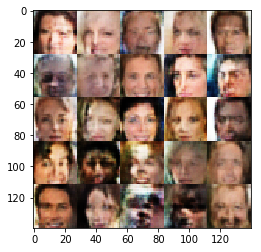

Epoch 1/1... Batch 3210... Discriminator Loss: 1.5555... Generator Loss: 0.4053
Epoch 1/1... Batch 3220... Discriminator Loss: 1.4662... Generator Loss: 0.4524
Epoch 1/1... Batch 3230... Discriminator Loss: 1.2338... Generator Loss: 0.7724
Epoch 1/1... Batch 3240... Discriminator Loss: 1.6120... Generator Loss: 0.4428
Epoch 1/1... Batch 3250... Discriminator Loss: 1.0705... Generator Loss: 0.8723
Epoch 1/1... Batch 3260... Discriminator Loss: 1.3771... Generator Loss: 0.6619
Epoch 1/1... Batch 3270... Discriminator Loss: 1.2303... Generator Loss: 0.8260
Epoch 1/1... Batch 3280... Discriminator Loss: 1.2926... Generator Loss: 0.7171
Epoch 1/1... Batch 3290... Discriminator Loss: 0.9152... Generator Loss: 1.0601
Epoch 1/1... Batch 3300... Discriminator Loss: 1.2294... Generator Loss: 0.9480


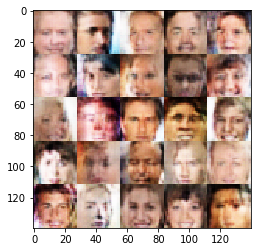

Epoch 1/1... Batch 3310... Discriminator Loss: 1.1152... Generator Loss: 0.7422
Epoch 1/1... Batch 3320... Discriminator Loss: 1.2243... Generator Loss: 0.7204
Epoch 1/1... Batch 3330... Discriminator Loss: 1.2477... Generator Loss: 0.7052
Epoch 1/1... Batch 3340... Discriminator Loss: 1.2894... Generator Loss: 0.6596
Epoch 1/1... Batch 3350... Discriminator Loss: 1.3788... Generator Loss: 0.5316
Epoch 1/1... Batch 3360... Discriminator Loss: 1.6405... Generator Loss: 0.3664
Epoch 1/1... Batch 3370... Discriminator Loss: 1.3044... Generator Loss: 0.7643
Epoch 1/1... Batch 3380... Discriminator Loss: 1.2359... Generator Loss: 0.7367
Epoch 1/1... Batch 3390... Discriminator Loss: 1.4743... Generator Loss: 0.4891
Epoch 1/1... Batch 3400... Discriminator Loss: 0.9115... Generator Loss: 1.1254


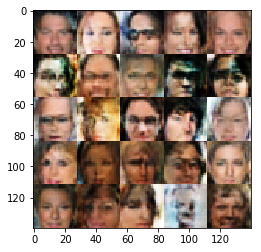

Epoch 1/1... Batch 3410... Discriminator Loss: 1.4629... Generator Loss: 1.2206
Epoch 1/1... Batch 3420... Discriminator Loss: 1.2455... Generator Loss: 0.8045
Epoch 1/1... Batch 3430... Discriminator Loss: 1.2442... Generator Loss: 0.7477
Epoch 1/1... Batch 3440... Discriminator Loss: 1.3438... Generator Loss: 0.9163
Epoch 1/1... Batch 3450... Discriminator Loss: 1.3631... Generator Loss: 0.6131
Epoch 1/1... Batch 3460... Discriminator Loss: 1.3430... Generator Loss: 1.3833
Epoch 1/1... Batch 3470... Discriminator Loss: 1.3831... Generator Loss: 0.6829
Epoch 1/1... Batch 3480... Discriminator Loss: 1.3005... Generator Loss: 0.7285
Epoch 1/1... Batch 3490... Discriminator Loss: 1.4010... Generator Loss: 0.5387
Epoch 1/1... Batch 3500... Discriminator Loss: 1.5835... Generator Loss: 0.5447


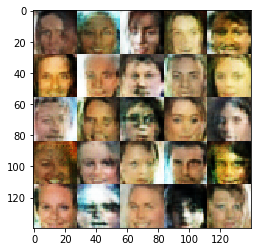

Epoch 1/1... Batch 3510... Discriminator Loss: 1.3310... Generator Loss: 0.7886
Epoch 1/1... Batch 3520... Discriminator Loss: 1.2384... Generator Loss: 0.7446
Epoch 1/1... Batch 3530... Discriminator Loss: 1.2429... Generator Loss: 0.6752
Epoch 1/1... Batch 3540... Discriminator Loss: 1.7091... Generator Loss: 0.3567
Epoch 1/1... Batch 3550... Discriminator Loss: 1.4513... Generator Loss: 0.5260
Epoch 1/1... Batch 3560... Discriminator Loss: 1.4040... Generator Loss: 0.7368
Epoch 1/1... Batch 3570... Discriminator Loss: 1.2642... Generator Loss: 0.6185
Epoch 1/1... Batch 3580... Discriminator Loss: 1.2913... Generator Loss: 0.6508
Epoch 1/1... Batch 3590... Discriminator Loss: 1.2559... Generator Loss: 0.7517
Epoch 1/1... Batch 3600... Discriminator Loss: 1.4332... Generator Loss: 0.5980


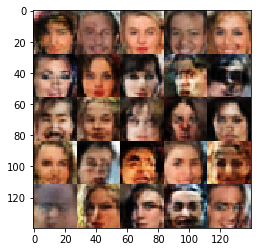

Epoch 1/1... Batch 3610... Discriminator Loss: 1.3305... Generator Loss: 0.7006
Epoch 1/1... Batch 3620... Discriminator Loss: 1.2405... Generator Loss: 0.7810
Epoch 1/1... Batch 3630... Discriminator Loss: 1.2413... Generator Loss: 0.7692
Epoch 1/1... Batch 3640... Discriminator Loss: 1.3216... Generator Loss: 0.6155
Epoch 1/1... Batch 3650... Discriminator Loss: 1.3629... Generator Loss: 0.5824
Epoch 1/1... Batch 3660... Discriminator Loss: 1.3712... Generator Loss: 0.5756
Epoch 1/1... Batch 3670... Discriminator Loss: 1.3154... Generator Loss: 0.6459
Epoch 1/1... Batch 3680... Discriminator Loss: 1.2481... Generator Loss: 0.7901
Epoch 1/1... Batch 3690... Discriminator Loss: 1.0994... Generator Loss: 0.8015
Epoch 1/1... Batch 3700... Discriminator Loss: 1.7731... Generator Loss: 0.3567


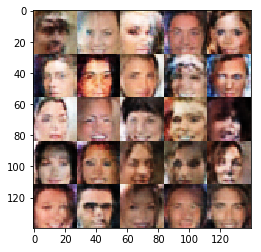

Epoch 1/1... Batch 3710... Discriminator Loss: 1.1344... Generator Loss: 0.8004
Epoch 1/1... Batch 3720... Discriminator Loss: 1.3531... Generator Loss: 0.6378
Epoch 1/1... Batch 3730... Discriminator Loss: 1.5240... Generator Loss: 0.5361
Epoch 1/1... Batch 3740... Discriminator Loss: 1.4326... Generator Loss: 0.6515
Epoch 1/1... Batch 3750... Discriminator Loss: 1.1384... Generator Loss: 0.7854
Epoch 1/1... Batch 3760... Discriminator Loss: 1.4462... Generator Loss: 0.8270
Epoch 1/1... Batch 3770... Discriminator Loss: 1.3062... Generator Loss: 0.5778
Epoch 1/1... Batch 3780... Discriminator Loss: 1.1551... Generator Loss: 0.7900
Epoch 1/1... Batch 3790... Discriminator Loss: 1.3367... Generator Loss: 0.6621
Epoch 1/1... Batch 3800... Discriminator Loss: 1.4536... Generator Loss: 0.4638


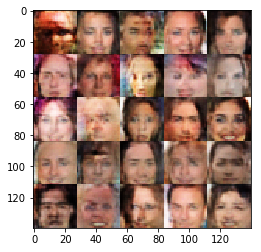

Epoch 1/1... Batch 3810... Discriminator Loss: 1.5552... Generator Loss: 0.4483
Epoch 1/1... Batch 3820... Discriminator Loss: 1.0966... Generator Loss: 0.8599
Epoch 1/1... Batch 3830... Discriminator Loss: 1.1329... Generator Loss: 1.0669
Epoch 1/1... Batch 3840... Discriminator Loss: 1.4226... Generator Loss: 0.5258
Epoch 1/1... Batch 3850... Discriminator Loss: 1.4276... Generator Loss: 0.5290
Epoch 1/1... Batch 3860... Discriminator Loss: 1.2394... Generator Loss: 0.6573
Epoch 1/1... Batch 3870... Discriminator Loss: 1.3568... Generator Loss: 0.7440
Epoch 1/1... Batch 3880... Discriminator Loss: 1.2362... Generator Loss: 0.6935
Epoch 1/1... Batch 3890... Discriminator Loss: 1.3413... Generator Loss: 0.5903
Epoch 1/1... Batch 3900... Discriminator Loss: 1.1048... Generator Loss: 0.7756


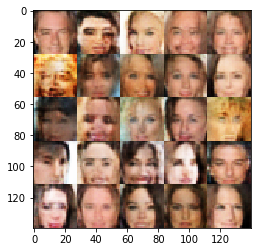

Epoch 1/1... Batch 3910... Discriminator Loss: 1.3624... Generator Loss: 0.5424
Epoch 1/1... Batch 3920... Discriminator Loss: 1.5879... Generator Loss: 0.4332
Epoch 1/1... Batch 3930... Discriminator Loss: 1.3501... Generator Loss: 0.6175
Epoch 1/1... Batch 3940... Discriminator Loss: 1.3919... Generator Loss: 0.5597
Epoch 1/1... Batch 3950... Discriminator Loss: 1.2118... Generator Loss: 0.7342
Epoch 1/1... Batch 3960... Discriminator Loss: 1.4817... Generator Loss: 0.5774
Epoch 1/1... Batch 3970... Discriminator Loss: 1.3338... Generator Loss: 0.5767
Epoch 1/1... Batch 3980... Discriminator Loss: 1.2466... Generator Loss: 0.6593
Epoch 1/1... Batch 3990... Discriminator Loss: 1.5334... Generator Loss: 0.5186
Epoch 1/1... Batch 4000... Discriminator Loss: 1.3868... Generator Loss: 0.7006


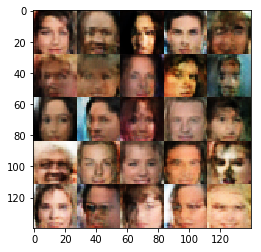

Epoch 1/1... Batch 4010... Discriminator Loss: 1.2391... Generator Loss: 0.7292
Epoch 1/1... Batch 4020... Discriminator Loss: 1.5515... Generator Loss: 0.4309
Epoch 1/1... Batch 4030... Discriminator Loss: 1.3540... Generator Loss: 0.6810
Epoch 1/1... Batch 4040... Discriminator Loss: 1.3981... Generator Loss: 0.6879
Epoch 1/1... Batch 4050... Discriminator Loss: 1.3287... Generator Loss: 0.6362
Epoch 1/1... Batch 4060... Discriminator Loss: 1.2747... Generator Loss: 0.8002
Epoch 1/1... Batch 4070... Discriminator Loss: 1.2496... Generator Loss: 0.8589
Epoch 1/1... Batch 4080... Discriminator Loss: 1.6291... Generator Loss: 0.3749
Epoch 1/1... Batch 4090... Discriminator Loss: 1.8684... Generator Loss: 0.2836
Epoch 1/1... Batch 4100... Discriminator Loss: 1.1975... Generator Loss: 0.9281


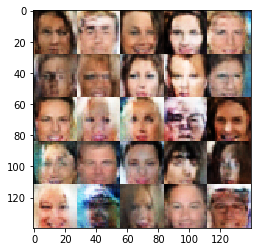

Epoch 1/1... Batch 4110... Discriminator Loss: 1.4025... Generator Loss: 0.6430
Epoch 1/1... Batch 4120... Discriminator Loss: 1.5004... Generator Loss: 0.4849
Epoch 1/1... Batch 4130... Discriminator Loss: 1.6642... Generator Loss: 0.4151
Epoch 1/1... Batch 4140... Discriminator Loss: 1.2755... Generator Loss: 0.8132
Epoch 1/1... Batch 4150... Discriminator Loss: 1.0351... Generator Loss: 0.9025
Epoch 1/1... Batch 4160... Discriminator Loss: 1.3437... Generator Loss: 0.5611
Epoch 1/1... Batch 4170... Discriminator Loss: 1.4876... Generator Loss: 0.4953
Epoch 1/1... Batch 4180... Discriminator Loss: 1.4781... Generator Loss: 0.4713
Epoch 1/1... Batch 4190... Discriminator Loss: 1.2245... Generator Loss: 0.6567
Epoch 1/1... Batch 4200... Discriminator Loss: 1.5816... Generator Loss: 0.3988


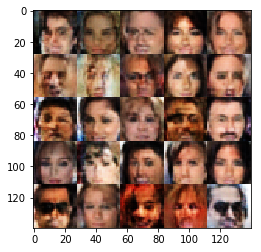

Epoch 1/1... Batch 4210... Discriminator Loss: 1.2783... Generator Loss: 0.6410
Epoch 1/1... Batch 4220... Discriminator Loss: 1.2309... Generator Loss: 0.9660
Epoch 1/1... Batch 4230... Discriminator Loss: 1.7703... Generator Loss: 0.3145
Epoch 1/1... Batch 4240... Discriminator Loss: 1.2030... Generator Loss: 0.8076
Epoch 1/1... Batch 4250... Discriminator Loss: 1.4420... Generator Loss: 0.5029
Epoch 1/1... Batch 4260... Discriminator Loss: 1.3406... Generator Loss: 0.5949
Epoch 1/1... Batch 4270... Discriminator Loss: 1.0383... Generator Loss: 1.1444
Epoch 1/1... Batch 4280... Discriminator Loss: 1.3187... Generator Loss: 0.8197
Epoch 1/1... Batch 4290... Discriminator Loss: 1.3140... Generator Loss: 0.6152
Epoch 1/1... Batch 4300... Discriminator Loss: 1.2637... Generator Loss: 0.6559


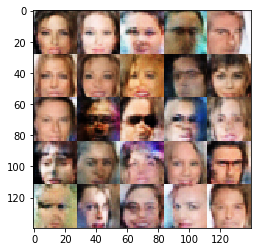

Epoch 1/1... Batch 4310... Discriminator Loss: 1.2147... Generator Loss: 0.7780
Epoch 1/1... Batch 4320... Discriminator Loss: 1.4144... Generator Loss: 0.5324
Epoch 1/1... Batch 4330... Discriminator Loss: 1.4236... Generator Loss: 0.5548
Epoch 1/1... Batch 4340... Discriminator Loss: 1.4896... Generator Loss: 0.4797
Epoch 1/1... Batch 4350... Discriminator Loss: 1.3723... Generator Loss: 0.5906
Epoch 1/1... Batch 4360... Discriminator Loss: 1.2407... Generator Loss: 0.7115
Epoch 1/1... Batch 4370... Discriminator Loss: 1.3107... Generator Loss: 0.5839
Epoch 1/1... Batch 4380... Discriminator Loss: 1.3385... Generator Loss: 0.6244
Epoch 1/1... Batch 4390... Discriminator Loss: 1.2920... Generator Loss: 0.8151
Epoch 1/1... Batch 4400... Discriminator Loss: 1.3685... Generator Loss: 0.6121


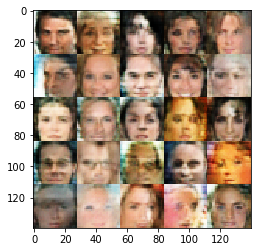

Epoch 1/1... Batch 4410... Discriminator Loss: 1.1808... Generator Loss: 0.8306
Epoch 1/1... Batch 4420... Discriminator Loss: 1.5556... Generator Loss: 0.4141
Epoch 1/1... Batch 4430... Discriminator Loss: 1.2593... Generator Loss: 0.7707
Epoch 1/1... Batch 4440... Discriminator Loss: 1.1807... Generator Loss: 0.8253
Epoch 1/1... Batch 4450... Discriminator Loss: 1.4028... Generator Loss: 1.3582
Epoch 1/1... Batch 4460... Discriminator Loss: 1.1213... Generator Loss: 0.7588
Epoch 1/1... Batch 4470... Discriminator Loss: 1.1799... Generator Loss: 0.6688
Epoch 1/1... Batch 4480... Discriminator Loss: 1.2403... Generator Loss: 0.8373
Epoch 1/1... Batch 4490... Discriminator Loss: 1.5888... Generator Loss: 0.3783
Epoch 1/1... Batch 4500... Discriminator Loss: 1.0852... Generator Loss: 0.7681


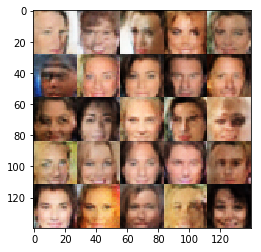

Epoch 1/1... Batch 4510... Discriminator Loss: 1.0532... Generator Loss: 0.9323
Epoch 1/1... Batch 4520... Discriminator Loss: 1.3965... Generator Loss: 0.7314
Epoch 1/1... Batch 4530... Discriminator Loss: 1.5906... Generator Loss: 0.4405
Epoch 1/1... Batch 4540... Discriminator Loss: 1.3392... Generator Loss: 0.6099
Epoch 1/1... Batch 4550... Discriminator Loss: 1.3679... Generator Loss: 0.6292
Epoch 1/1... Batch 4560... Discriminator Loss: 1.4211... Generator Loss: 0.5997
Epoch 1/1... Batch 4570... Discriminator Loss: 1.4215... Generator Loss: 0.6871
Epoch 1/1... Batch 4580... Discriminator Loss: 1.5204... Generator Loss: 0.6617
Epoch 1/1... Batch 4590... Discriminator Loss: 1.4944... Generator Loss: 0.4730
Epoch 1/1... Batch 4600... Discriminator Loss: 1.2774... Generator Loss: 0.6935


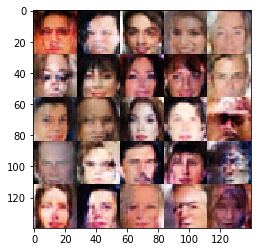

Epoch 1/1... Batch 4610... Discriminator Loss: 1.2826... Generator Loss: 0.7634
Epoch 1/1... Batch 4620... Discriminator Loss: 1.2305... Generator Loss: 0.6587
Epoch 1/1... Batch 4630... Discriminator Loss: 1.5350... Generator Loss: 0.5410
Epoch 1/1... Batch 4640... Discriminator Loss: 1.2408... Generator Loss: 0.7392
Epoch 1/1... Batch 4650... Discriminator Loss: 1.3752... Generator Loss: 0.6198
Epoch 1/1... Batch 4660... Discriminator Loss: 1.1695... Generator Loss: 0.8367
Epoch 1/1... Batch 4670... Discriminator Loss: 1.2705... Generator Loss: 0.8746
Epoch 1/1... Batch 4680... Discriminator Loss: 1.8271... Generator Loss: 0.3281
Epoch 1/1... Batch 4690... Discriminator Loss: 1.3144... Generator Loss: 0.7462
Epoch 1/1... Batch 4700... Discriminator Loss: 1.4578... Generator Loss: 0.5223


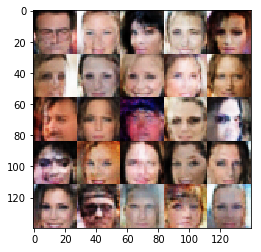

Epoch 1/1... Batch 4710... Discriminator Loss: 1.4961... Generator Loss: 0.5786
Epoch 1/1... Batch 4720... Discriminator Loss: 1.3986... Generator Loss: 0.5550
Epoch 1/1... Batch 4730... Discriminator Loss: 1.4175... Generator Loss: 0.6035
Epoch 1/1... Batch 4740... Discriminator Loss: 1.6442... Generator Loss: 0.3998
Epoch 1/1... Batch 4750... Discriminator Loss: 1.2876... Generator Loss: 0.7364
Epoch 1/1... Batch 4760... Discriminator Loss: 1.4079... Generator Loss: 0.5733
Epoch 1/1... Batch 4770... Discriminator Loss: 1.2541... Generator Loss: 0.6384
Epoch 1/1... Batch 4780... Discriminator Loss: 1.4276... Generator Loss: 0.4921
Epoch 1/1... Batch 4790... Discriminator Loss: 1.4582... Generator Loss: 0.5024
Epoch 1/1... Batch 4800... Discriminator Loss: 1.3929... Generator Loss: 0.5357


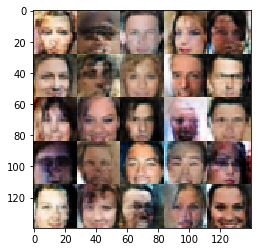

Epoch 1/1... Batch 4810... Discriminator Loss: 1.2136... Generator Loss: 0.7904
Epoch 1/1... Batch 4820... Discriminator Loss: 1.3301... Generator Loss: 0.6144
Epoch 1/1... Batch 4830... Discriminator Loss: 1.6231... Generator Loss: 0.5827
Epoch 1/1... Batch 4840... Discriminator Loss: 1.4014... Generator Loss: 0.6630
Epoch 1/1... Batch 4850... Discriminator Loss: 1.3645... Generator Loss: 0.9160
Epoch 1/1... Batch 4860... Discriminator Loss: 1.1457... Generator Loss: 0.7845
Epoch 1/1... Batch 4870... Discriminator Loss: 1.2447... Generator Loss: 0.7107
Epoch 1/1... Batch 4880... Discriminator Loss: 1.4734... Generator Loss: 0.5946
Epoch 1/1... Batch 4890... Discriminator Loss: 1.3980... Generator Loss: 0.5490
Epoch 1/1... Batch 4900... Discriminator Loss: 1.2125... Generator Loss: 0.7990


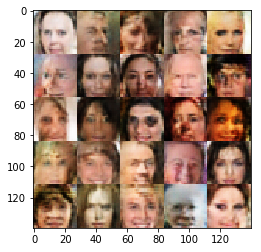

Epoch 1/1... Batch 4910... Discriminator Loss: 1.2984... Generator Loss: 0.6832
Epoch 1/1... Batch 4920... Discriminator Loss: 1.2875... Generator Loss: 0.7213
Epoch 1/1... Batch 4930... Discriminator Loss: 1.3139... Generator Loss: 0.6333
Epoch 1/1... Batch 4940... Discriminator Loss: 1.3957... Generator Loss: 0.6080
Epoch 1/1... Batch 4950... Discriminator Loss: 1.4617... Generator Loss: 0.5651
Epoch 1/1... Batch 4960... Discriminator Loss: 1.2614... Generator Loss: 0.6384
Epoch 1/1... Batch 4970... Discriminator Loss: 1.4878... Generator Loss: 0.5607
Epoch 1/1... Batch 4980... Discriminator Loss: 1.1203... Generator Loss: 0.8796
Epoch 1/1... Batch 4990... Discriminator Loss: 1.3776... Generator Loss: 0.7310
Epoch 1/1... Batch 5000... Discriminator Loss: 1.1097... Generator Loss: 0.9419


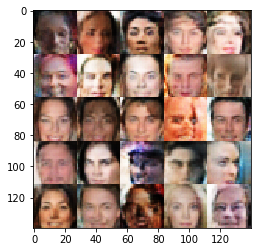

Epoch 1/1... Batch 5010... Discriminator Loss: 1.4259... Generator Loss: 0.5363
Epoch 1/1... Batch 5020... Discriminator Loss: 1.4472... Generator Loss: 0.5178
Epoch 1/1... Batch 5030... Discriminator Loss: 1.4565... Generator Loss: 0.5115
Epoch 1/1... Batch 5040... Discriminator Loss: 1.0186... Generator Loss: 1.2394
Epoch 1/1... Batch 5050... Discriminator Loss: 1.3495... Generator Loss: 0.6403
Epoch 1/1... Batch 5060... Discriminator Loss: 1.3523... Generator Loss: 0.6221
Epoch 1/1... Batch 5070... Discriminator Loss: 1.3208... Generator Loss: 0.6258
Epoch 1/1... Batch 5080... Discriminator Loss: 1.2540... Generator Loss: 0.7265
Epoch 1/1... Batch 5090... Discriminator Loss: 1.3433... Generator Loss: 0.6423
Epoch 1/1... Batch 5100... Discriminator Loss: 1.4031... Generator Loss: 0.5532


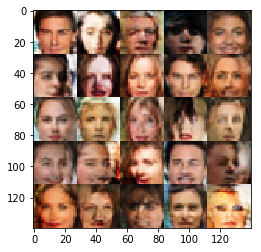

Epoch 1/1... Batch 5110... Discriminator Loss: 1.3065... Generator Loss: 0.6118
Epoch 1/1... Batch 5120... Discriminator Loss: 1.3136... Generator Loss: 0.7649
Epoch 1/1... Batch 5130... Discriminator Loss: 1.5026... Generator Loss: 0.4834
Epoch 1/1... Batch 5140... Discriminator Loss: 1.3617... Generator Loss: 0.6347
Epoch 1/1... Batch 5150... Discriminator Loss: 1.7541... Generator Loss: 0.4163
Epoch 1/1... Batch 5160... Discriminator Loss: 1.2634... Generator Loss: 0.6700
Epoch 1/1... Batch 5170... Discriminator Loss: 1.3400... Generator Loss: 0.6124
Epoch 1/1... Batch 5180... Discriminator Loss: 1.5568... Generator Loss: 0.4497
Epoch 1/1... Batch 5190... Discriminator Loss: 1.3719... Generator Loss: 0.5870
Epoch 1/1... Batch 5200... Discriminator Loss: 1.5173... Generator Loss: 0.4815


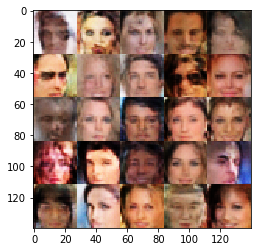

Epoch 1/1... Batch 5210... Discriminator Loss: 1.2231... Generator Loss: 0.7090
Epoch 1/1... Batch 5220... Discriminator Loss: 1.1511... Generator Loss: 0.7545
Epoch 1/1... Batch 5230... Discriminator Loss: 1.4228... Generator Loss: 1.1065
Epoch 1/1... Batch 5240... Discriminator Loss: 1.5783... Generator Loss: 0.4727
Epoch 1/1... Batch 5250... Discriminator Loss: 1.3601... Generator Loss: 0.5836
Epoch 1/1... Batch 5260... Discriminator Loss: 1.2301... Generator Loss: 0.9065
Epoch 1/1... Batch 5270... Discriminator Loss: 1.3631... Generator Loss: 0.5306
Epoch 1/1... Batch 5280... Discriminator Loss: 1.5367... Generator Loss: 0.4156
Epoch 1/1... Batch 5290... Discriminator Loss: 1.2658... Generator Loss: 0.6867
Epoch 1/1... Batch 5300... Discriminator Loss: 1.3571... Generator Loss: 0.6399


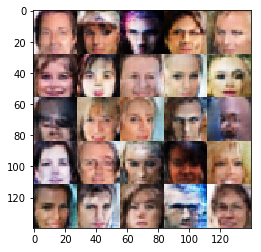

Epoch 1/1... Batch 5310... Discriminator Loss: 1.2157... Generator Loss: 0.9350
Epoch 1/1... Batch 5320... Discriminator Loss: 1.3164... Generator Loss: 0.6856
Epoch 1/1... Batch 5330... Discriminator Loss: 1.4234... Generator Loss: 0.6372
Epoch 1/1... Batch 5340... Discriminator Loss: 1.4902... Generator Loss: 0.6569
Epoch 1/1... Batch 5350... Discriminator Loss: 1.2988... Generator Loss: 0.8036
Epoch 1/1... Batch 5360... Discriminator Loss: 1.2675... Generator Loss: 0.9370
Epoch 1/1... Batch 5370... Discriminator Loss: 1.2341... Generator Loss: 0.7675
Epoch 1/1... Batch 5380... Discriminator Loss: 1.1470... Generator Loss: 0.8814
Epoch 1/1... Batch 5390... Discriminator Loss: 1.2847... Generator Loss: 0.6942
Epoch 1/1... Batch 5400... Discriminator Loss: 1.2341... Generator Loss: 0.7108


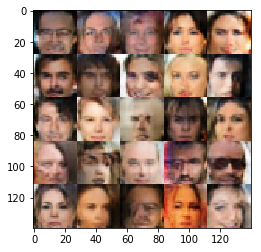

Epoch 1/1... Batch 5410... Discriminator Loss: 1.3689... Generator Loss: 0.5066
Epoch 1/1... Batch 5420... Discriminator Loss: 1.0910... Generator Loss: 0.9345
Epoch 1/1... Batch 5430... Discriminator Loss: 1.1551... Generator Loss: 1.0922
Epoch 1/1... Batch 5440... Discriminator Loss: 1.7821... Generator Loss: 0.3072
Epoch 1/1... Batch 5450... Discriminator Loss: 1.1745... Generator Loss: 0.8410
Epoch 1/1... Batch 5460... Discriminator Loss: 1.3435... Generator Loss: 0.7534
Epoch 1/1... Batch 5470... Discriminator Loss: 1.3982... Generator Loss: 0.5448
Epoch 1/1... Batch 5480... Discriminator Loss: 1.3850... Generator Loss: 0.5314
Epoch 1/1... Batch 5490... Discriminator Loss: 1.4917... Generator Loss: 0.4945
Epoch 1/1... Batch 5500... Discriminator Loss: 1.1429... Generator Loss: 0.8294


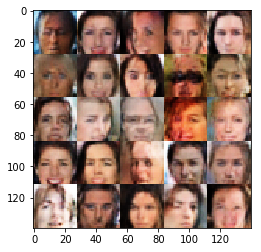

Epoch 1/1... Batch 5510... Discriminator Loss: 1.2071... Generator Loss: 0.7471
Epoch 1/1... Batch 5520... Discriminator Loss: 1.3522... Generator Loss: 0.5422
Epoch 1/1... Batch 5530... Discriminator Loss: 1.7954... Generator Loss: 0.2974
Epoch 1/1... Batch 5540... Discriminator Loss: 1.1015... Generator Loss: 0.8245
Epoch 1/1... Batch 5550... Discriminator Loss: 1.3845... Generator Loss: 0.6782
Epoch 1/1... Batch 5560... Discriminator Loss: 1.1196... Generator Loss: 1.0149
Epoch 1/1... Batch 5570... Discriminator Loss: 1.2364... Generator Loss: 0.8477
Epoch 1/1... Batch 5580... Discriminator Loss: 1.2173... Generator Loss: 0.8226
Epoch 1/1... Batch 5590... Discriminator Loss: 1.5840... Generator Loss: 0.4082
Epoch 1/1... Batch 5600... Discriminator Loss: 1.2851... Generator Loss: 0.6333


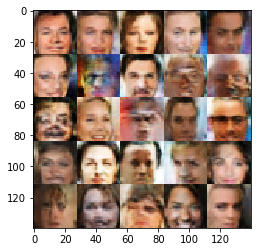

Epoch 1/1... Batch 5610... Discriminator Loss: 1.1967... Generator Loss: 0.7782
Epoch 1/1... Batch 5620... Discriminator Loss: 1.4303... Generator Loss: 0.8831
Epoch 1/1... Batch 5630... Discriminator Loss: 1.4401... Generator Loss: 0.7470
Epoch 1/1... Batch 5640... Discriminator Loss: 1.6925... Generator Loss: 0.4177
Epoch 1/1... Batch 5650... Discriminator Loss: 1.4645... Generator Loss: 0.4900
Epoch 1/1... Batch 5660... Discriminator Loss: 1.3235... Generator Loss: 0.6342
Epoch 1/1... Batch 5670... Discriminator Loss: 1.2457... Generator Loss: 0.8338
Epoch 1/1... Batch 5680... Discriminator Loss: 1.3177... Generator Loss: 0.5832
Epoch 1/1... Batch 5690... Discriminator Loss: 1.2055... Generator Loss: 0.8119
Epoch 1/1... Batch 5700... Discriminator Loss: 1.3213... Generator Loss: 1.2049


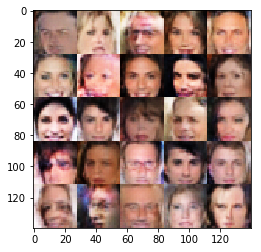

Epoch 1/1... Batch 5710... Discriminator Loss: 1.4725... Generator Loss: 0.8401
Epoch 1/1... Batch 5720... Discriminator Loss: 1.5460... Generator Loss: 0.4846
Epoch 1/1... Batch 5730... Discriminator Loss: 1.3496... Generator Loss: 0.6730
Epoch 1/1... Batch 5740... Discriminator Loss: 1.5432... Generator Loss: 0.4435
Epoch 1/1... Batch 5750... Discriminator Loss: 1.2208... Generator Loss: 0.7910
Epoch 1/1... Batch 5760... Discriminator Loss: 1.1573... Generator Loss: 0.7938
Epoch 1/1... Batch 5770... Discriminator Loss: 1.4450... Generator Loss: 0.5046
Epoch 1/1... Batch 5780... Discriminator Loss: 1.5013... Generator Loss: 0.4371
Epoch 1/1... Batch 5790... Discriminator Loss: 1.4674... Generator Loss: 0.6723
Epoch 1/1... Batch 5800... Discriminator Loss: 1.4223... Generator Loss: 0.5789


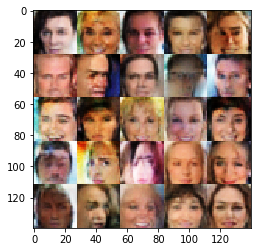

Epoch 1/1... Batch 5810... Discriminator Loss: 1.2763... Generator Loss: 0.6838
Epoch 1/1... Batch 5820... Discriminator Loss: 1.5084... Generator Loss: 0.4554
Epoch 1/1... Batch 5830... Discriminator Loss: 1.4685... Generator Loss: 0.4621
Epoch 1/1... Batch 5840... Discriminator Loss: 1.4181... Generator Loss: 0.5236
Epoch 1/1... Batch 5850... Discriminator Loss: 1.3988... Generator Loss: 0.8207
Epoch 1/1... Batch 5860... Discriminator Loss: 1.2328... Generator Loss: 1.0115
Epoch 1/1... Batch 5870... Discriminator Loss: 1.1836... Generator Loss: 0.7583
Epoch 1/1... Batch 5880... Discriminator Loss: 1.5161... Generator Loss: 0.4225
Epoch 1/1... Batch 5890... Discriminator Loss: 1.5746... Generator Loss: 0.4146
Epoch 1/1... Batch 5900... Discriminator Loss: 1.4999... Generator Loss: 0.9457


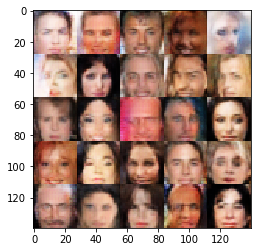

Epoch 1/1... Batch 5910... Discriminator Loss: 1.3540... Generator Loss: 0.7246
Epoch 1/1... Batch 5920... Discriminator Loss: 1.3795... Generator Loss: 0.5576
Epoch 1/1... Batch 5930... Discriminator Loss: 1.3151... Generator Loss: 0.7160
Epoch 1/1... Batch 5940... Discriminator Loss: 1.2605... Generator Loss: 0.6513
Epoch 1/1... Batch 5950... Discriminator Loss: 1.6568... Generator Loss: 0.3689
Epoch 1/1... Batch 5960... Discriminator Loss: 1.4364... Generator Loss: 0.6197
Epoch 1/1... Batch 5970... Discriminator Loss: 1.1850... Generator Loss: 0.7271
Epoch 1/1... Batch 5980... Discriminator Loss: 1.2999... Generator Loss: 0.7046
Epoch 1/1... Batch 5990... Discriminator Loss: 1.3484... Generator Loss: 0.6341
Epoch 1/1... Batch 6000... Discriminator Loss: 1.1930... Generator Loss: 0.7385


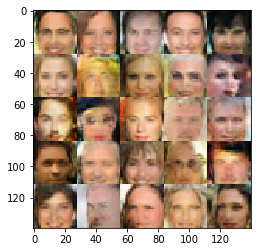

Epoch 1/1... Batch 6010... Discriminator Loss: 1.2317... Generator Loss: 0.7922
Epoch 1/1... Batch 6020... Discriminator Loss: 1.5485... Generator Loss: 0.4339
Epoch 1/1... Batch 6030... Discriminator Loss: 1.2648... Generator Loss: 0.6926
Epoch 1/1... Batch 6040... Discriminator Loss: 1.3216... Generator Loss: 0.6449
Epoch 1/1... Batch 6050... Discriminator Loss: 1.1500... Generator Loss: 1.1507
Epoch 1/1... Batch 6060... Discriminator Loss: 1.4718... Generator Loss: 0.5296
Epoch 1/1... Batch 6070... Discriminator Loss: 1.5493... Generator Loss: 0.5039
Epoch 1/1... Batch 6080... Discriminator Loss: 1.3677... Generator Loss: 0.6572
Epoch 1/1... Batch 6090... Discriminator Loss: 1.3142... Generator Loss: 0.6170
Epoch 1/1... Batch 6100... Discriminator Loss: 1.4043... Generator Loss: 0.5712


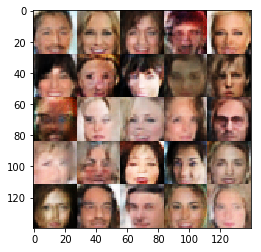

Epoch 1/1... Batch 6110... Discriminator Loss: 1.5144... Generator Loss: 0.4359
Epoch 1/1... Batch 6120... Discriminator Loss: 1.2770... Generator Loss: 0.8088
Epoch 1/1... Batch 6130... Discriminator Loss: 1.4446... Generator Loss: 0.5387
Epoch 1/1... Batch 6140... Discriminator Loss: 1.1820... Generator Loss: 0.7838
Epoch 1/1... Batch 6150... Discriminator Loss: 1.4056... Generator Loss: 0.7198
Epoch 1/1... Batch 6160... Discriminator Loss: 1.5155... Generator Loss: 0.5865
Epoch 1/1... Batch 6170... Discriminator Loss: 1.5027... Generator Loss: 0.4893
Epoch 1/1... Batch 6180... Discriminator Loss: 1.3739... Generator Loss: 0.6497
Epoch 1/1... Batch 6190... Discriminator Loss: 1.4211... Generator Loss: 0.7369
Epoch 1/1... Batch 6200... Discriminator Loss: 1.4272... Generator Loss: 0.5431


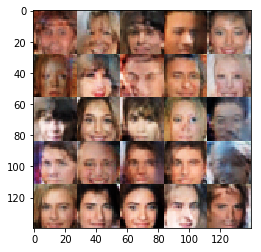

Epoch 1/1... Batch 6210... Discriminator Loss: 1.5750... Generator Loss: 0.4331
Epoch 1/1... Batch 6220... Discriminator Loss: 0.9764... Generator Loss: 0.9188
Epoch 1/1... Batch 6230... Discriminator Loss: 1.3610... Generator Loss: 0.7015
Epoch 1/1... Batch 6240... Discriminator Loss: 1.3930... Generator Loss: 0.7260
Epoch 1/1... Batch 6250... Discriminator Loss: 1.3712... Generator Loss: 0.7670
Epoch 1/1... Batch 6260... Discriminator Loss: 1.3934... Generator Loss: 0.6615
Epoch 1/1... Batch 6270... Discriminator Loss: 1.5307... Generator Loss: 0.4360
Epoch 1/1... Batch 6280... Discriminator Loss: 1.2804... Generator Loss: 0.7036
Epoch 1/1... Batch 6290... Discriminator Loss: 1.4726... Generator Loss: 0.4608
Epoch 1/1... Batch 6300... Discriminator Loss: 1.5325... Generator Loss: 0.4898


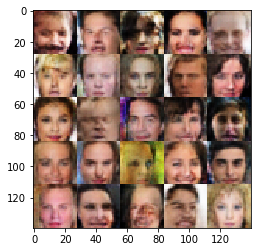

Epoch 1/1... Batch 6310... Discriminator Loss: 1.4871... Generator Loss: 0.4775
Epoch 1/1... Batch 6320... Discriminator Loss: 1.2809... Generator Loss: 0.8852
Epoch 1/1... Batch 6330... Discriminator Loss: 1.5515... Generator Loss: 0.5113


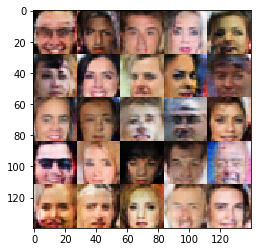

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.